In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
mkdir 'asd'

In [23]:
# %cd /content/drive/MyDrive/Colab Notebooks/dacon

%cd /content
%mkdir data
%cd /content/data
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/dacon/open.zip"

/content
mkdir: cannot create directory ‘data’: File exists
/content/data


In [24]:
#이미지 개수 파악
from glob import glob
filepaths = list(glob('/content/drive/MyDrive/Colab Notebooks/dacon/image/train/*.jpg'))
filepaths = list(glob('/content/data/image/train/*.jpg'))
len(filepaths)

16986

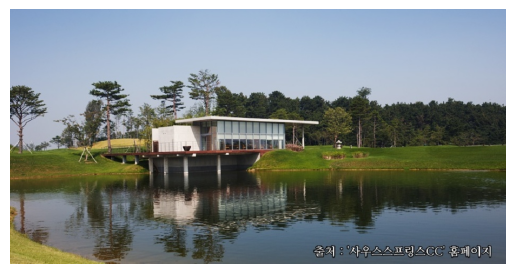

In [45]:
#이미지 열기
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 파일 경로
image_path = "/content/drive/MyDrive/Colab Notebooks/dacon/image/train/TRAIN_16985.jpg"
image_path = all_df.loc[1,'img_path']
# 이미지 열기
image = Image.open(image_path)

# 이미지 보여주기
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

In [25]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [30]:
# %cd /content/drive/MyDrive/Colab Notebooks/dacon
%cd /content/data
# df = pd.read_csv('train.csv')
# !pwd

/content/data


In [31]:

all_df = pd.read_csv('train.csv')
train_df, val_df, _, _ = train_test_split(all_df, all_df['cat3'], test_size=0.2, random_state=CFG['SEED'])
# category -> label
le = preprocessing.LabelEncoder()
le.fit(train_df['cat3'].values)
train_df['cat3'] = le.transform(train_df['cat3'].values)
val_df['cat3'] = le.transform(val_df['cat3'].values)

# 단어 수 세기
vectorizer = CountVectorizer(max_features=4096)

# train_vectors = vectorizer.fit_transform(train_df['overview'])
tokens = tokenizer(text, return_tensors="pt")
output = model(**tokens)

# 희소 행렬을 밀집 행렬 형태로 변환
train_vectors = train_vectors.todense()

val_vectors = vectorizer.transform(val_df['overview'])
# 희소 행렬을 밀집 행렬 형태로 변환
val_vectors = val_vectors.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [32]:
class CustomDataset(Dataset):
    """ 전처리 """
    def __init__(self, img_path_list, text_vectors, label_list, transforms, infer=False):
        self.img_path_list = img_path_list
        self.text_vectors = text_vectors
        self.label_list = label_list
        self.transforms = transforms
        self.infer = infer


    def __getitem__(self, index):
        # NLP
        text_vector = self.text_vectors[index]

        # Image

        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        # Label
        if self.infer:
            return image, torch.Tensor(text_vector).view(-1)
        else:
            label = self.label_list[index]
            return image, torch.Tensor(text_vector).view(-1), label

    def __len__(self):
        return len(self.img_path_list)

In [33]:
# resize 그 사이즈로 변환
# norm: 이미지 각 채널의 평균, 표준편차 로 정규화 하는 작업.
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])
test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])
train_dataset = CustomDataset(train_df['img_path'].values, train_vectors, train_df['cat3'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(val_df['img_path'].values, val_vectors, val_df['cat3'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [62]:
train_dataset[5]

(tensor([[[ 1.2214,  1.5639,  1.4783,  ...,  2.1462,  2.0948,  2.0263],
          [ 1.0844,  1.3242,  1.2899,  ...,  2.1119,  2.1462,  2.1975],
          [ 1.7009,  1.1872,  1.4269,  ...,  2.1804,  2.1804,  2.0948],
          ...,
          [-1.8953, -2.0494, -1.9809,  ..., -2.0665, -2.0323, -2.0665],
          [-2.1008, -1.9980, -1.9124,  ..., -2.0323, -2.0837, -2.0494],
          [-1.9809, -2.0494, -2.0665,  ..., -1.0733, -1.1932, -1.3130]],
 
         [[ 0.7479,  1.2206,  1.0455,  ...,  1.9734,  1.8859,  1.8508],
          [ 0.5728,  0.7829,  0.8704,  ...,  1.9384,  1.9384,  1.9909],
          [ 1.4657,  0.6954,  0.9930,  ...,  2.0084,  2.0084,  1.8859],
          ...,
          [-1.7031, -1.9307, -1.8256,  ..., -1.9657, -1.9307, -1.9657],
          [-1.9307, -1.9132, -1.7731,  ..., -1.8782, -1.9657, -1.9307],
          [-1.8957, -2.0007, -1.9657,  ..., -0.9153, -1.0728, -1.1954]],
 
         [[ 0.6879,  1.2631,  1.0191,  ...,  2.0997,  2.0125,  1.9777],
          [ 0.5485,  0.6879,

In [47]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        #명시적인
        # super(CustomModel, self).__init__()
        # 간략화
        super().__init__()

        # Image Model
        self.cnn_extract = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Text Model
        self.nlp_extract = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
        )
        # Classifier (분류기)
        self.classifier = nn.Sequential(
            nn.Linear(4160, num_classes)
        )

    # 순전파
    def forward(self, img, text):
        img_feature = self.cnn_extract(img)
        img_feature = torch.flatten(img_feature, start_dim=1)
        text_feature = self.nlp_extract(text)
        feature = torch.cat([img_feature, text_feature], axis=1)
        output = self.classifier(feature)
        return output

In [48]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):

    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    best_model = None
    # 에폭 수행
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        # train
        for img, text, label in tqdm(iter(train_loader)):
            img = img.float().to(device)
            text = text.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            model_pred = model(img, text)

            # loss = criterion(model_pred, label)
            loss = F.cross_entropy(model_pred, label)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        # train_loss
        tr_loss = np.mean(train_loss)

        # validation
        val_loss, val_score = validation(model, criterion, val_loader, device)

        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step()

        if best_score < val_score:
            best_score = val_score
            best_model = model

    return best_model

In [49]:
def score_function(real, pred):
    return f1_score(real, pred, average="weighted")

def validation(model, criterion, val_loader, device):
    #  학습 중에만 필요한 기능이 비활성화되므로, 메모리 사용량이 줄어들고 추론 시에 더 빠른 속도를 제공할 수 있습니다.
    # train 모드, eval 모드가 있다.
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad(): # 순전파만 수행
        for img, text, label in tqdm(iter(val_loader)):
            img = img.float().to(device)
            text = text.to(device)
            label = label.to(device)

            model_pred = model(img, text)

            loss = criterion(model_pred, label)

            val_loss.append(loss.item())

            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

    test_weighted_f1 = score_function(true_labels, model_preds)
    return np.mean(val_loss), test_weighted_f1

In [ ]:
model = CustomModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

In [52]:
test_df = pd.read_csv('./test.csv')
test_vectors = vectorizer.transform(test_df['overview'])
test_vectors = test_vectors.todense()

In [53]:
test_dataset = CustomDataset(test_df['img_path'].values, test_vectors, None, test_transform, True)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [54]:
def inference(model, test_loader, deivce):
    model.to(device)
    model.eval()

    model_preds = []

    with torch.no_grad():
        for img, text in tqdm(iter(test_loader)):
            img = img.float().to(device)
            text = text.to(device)

            model_pred = model(img, text)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()

    return model_preds



preds = inference(infer_model, test_loader, device)



## Submission

# submit = pd.read_csv('./sample_submission.csv')
# submit['cat3'] = le.inverse_transform(preds)
# submit.to_csv('./submit.csv', index=False)

  0%|          | 0/114 [00:00<?, ?it/s]

In [59]:
# 모델 저장
# torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/dacon/model/model_1.pth')

# 모델 로드
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/dacon/model/model_1.pth'))
model.eval()

CustomModel(
  (cnn_extract): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (nlp_extract): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4160, out_features=128

In [64]:
!pip3 install transformers
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained("klue/roberta-large")
tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.8 MB/s eta 0:00:00


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# 문장을 토큰화
text = "KLUE RoBERTa-large 모델을 사용하는 예시입니다."
tokens = tokenizer(text, return_tensors="pt")

# 출력 확인
print(tokens)

{'input_ids': tensor([[    0,    47,  2237,  2309,  2105, 25145,  2206, 10646,  2081,  2011,
            17, 20563,  2008,  8398,  4347,  2069,  3704,  2205,  2259, 18369,
         12190,    18,     2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [67]:
output = model(**tokens)

In [68]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-4.4793e-02,  1.8674e-01, -3.0654e-01,  ..., -1.6489e-01,
           1.2388e-01,  1.0836e-01],
         [-7.0460e-01,  1.5305e-01, -1.8407e-01,  ..., -4.3365e-01,
           5.1402e-01, -1.8332e-01],
         [ 5.2738e-02, -9.1751e-02,  4.5351e-01,  ..., -2.2967e-01,
          -4.8689e-04,  2.7312e-01],
         ...,
         [ 9.3803e-02, -2.5725e-01,  4.0032e-01,  ..., -2.4162e-01,
          -3.6415e-01,  8.1058e-01],
         [-1.7018e-02, -7.4553e-02, -1.8562e-01,  ..., -3.9107e-02,
           1.2378e-01,  3.4059e-01],
         [-2.7468e-02,  1.9288e-01, -3.0454e-01,  ..., -1.5729e-01,
           1.3041e-01,  1.1323e-01]]], grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.3212,  0.5974,  0.3078,  ...,  0.4577, -0.3586,  0.1310]],
       grad_fn=<TanhBackward0>), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)

In [69]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [73]:
train_vectors = vectorizer.fit_transform(train_df['overview'])
# tokens = tokenizer(text, return_tensors="pt")
# output = model(**tokens)

# 희소 행렬을 밀집 행렬 형태로 변환
train_vectors = train_vectors.todense()


In [76]:
len(train_vectors[0])

1

In [ ]:
for i in train_df['overview']:
    print(i)